# Unsupervised Learning

In this notebook the code for the article of the second work of Artificial
Intelligence. This notebook was tested with `julia 1.5.1`.

## Dependencies
The version for each dependency is
- `Colors 0.12.4`
- `CSV 0.7.7`
- `Distributions 0.23.10`
- `FFTW 1.2.4`
- `Plots 1.6.0`
- `RDatasets 0.6.10`
- `StatsBase 0.33.1`
- `TSne 1.2.0`
- `Wavelets 0.9.2`

To install the latest versions for this dependencies, execute the following
cell.

In [ ]:
using Pkg

Pkg.add(name = "Colors", version = "0.12.4")
Pkg.add(name = "CSV", version = "0.7.7")
Pkg.add(name = "Distributions", version = "0.23.10")
Pkg.add(name = "FFTW", version = "1.2.4")
Pkg.add(name = "LaTeXStrings", version = "1.2.0")
Pkg.add(name = "Plots", version = "1.6.0")
Pkg.add(name = "RDatasets", version = "0.6.10")
Pkg.add(name = "StatsBase", version = "0.33.1")
Pkg.add(name = "TSne", version = "1.2.0")
Pkg.add(name = "Wavelets", version = "0.9.2")


Global packages and behavior.


In [1]:
using Colors
using CSV
using Distributions
using FFTW
using LaTeXStrings
using LinearAlgebra
using Plots
using Random
using RDatasets
using StatsBase
using Statistics
using TSne

default(show = true)
dir_fig = x -> string("../article/figs/", x);


## Norm Functions
In this section you will find an implementation for different norm functions.
Each of the norm functions have the following parameters:

- `data` which is a matrix of size *nxm*, with _n_ being the number of data
  points and _m_ the number of dimensions that the data point has.
- `center` is a vector of size _m_.
- `norm` determines if the norm or the distance is calculated.

If `norm` is `true` the norm squared of the subtraction of each row of `data`
and `center` will be calculated. Otherwise, the distance between the same data
points will be calculated. Other parameters are dependent on the norm function
applied and will be explained in each cell.


In [3]:
function euclidean(data, center; norm = false)
    center_aux = reshape(center, 1, length(center))
    diff = data .- center_aux
    value = sum(diff .^ 2, dims = 2)
    if norm
        return value
    end

    return sqrt.(value)
end;


In [4]:
function manhattan(data, center; norm = false)
    center_aux = reshape(center, 1, length(center))
    diff = data .- center_aux
    if norm
        return abs.(sum(diff, dims = 2)) .^ 2
    end

    return abs.(sum(diff, dims = 2))
end;


In [5]:
function mahalanobis(data, center, IS; norm = false)
    center_aux = reshape(center, 1, length(center))
    diff = data .- center_aux
    aux = (diff * IS) .* diff
    if norm
        return sum(aux, dims = 2)
    end

    return sqrt.(sum(aux, dims = 2))
end;


## Plotters

The function `plot_clusters` plots a data set colorized by the different
clusters of each group. It receives:
- `proto` which is a matrix of size *kxm* that contains each of the centroids
  for each group.
- `memberships` is a matrix of size *kxn* that contains to which of the groups a
  data point belongs.
- `data` is a matrix of size *nxm* that contains the data set.
- `pos` is a symbol that has the position of the labels in the plot.


In [6]:
function plot_clusters(proto, memberships, data, pos; xlabel = "x", ylabel = "y")
    plot_protos = !isempty(proto)
    xs = []
    ys = []
    labels = []
    for j in 1:size(memberships)[1]
        data_aux = data[findall(x -> x == 1, memberships[j, :]), :]
        push!(xs, data_aux[:, 1])
        push!(ys, data_aux[:, 2])
        push!(labels, string("Group ", j))
    end
    if plot_protos
        push!(xs, proto[:, 1])
        push!(ys, proto[:, 2])
        push!(labels, "Centers")
    end
    labels = reshape(labels, 1, :)
    scatter(xs, ys,
            fmt = :png,
            label = labels,
            legend = pos,
            markersize = 5,
            markerstrokewidth=0,
            palette=:darkrainbow,
            xlabel = xlabel,
            ylabel = ylabel)
end;


The function `plot_clusters3d` haves a similar behavior to the function defined
above, but for 3d data. The aditional parameter `camera` is a tuple that
represent the azimuth and altitude for which the plot is shown.


In [7]:
function plot_clusters3d(proto, memberships, data, pos, camera, xlabel, ylabel, zlabel)
    xs = []
    ys = []
    zs = []
    labels = []
    for j in 1:size(proto)[1]
        data_aux = data[findall(x -> x == 1, memberships[j, :]), :]
        push!(xs, data_aux[:, 1])
        push!(ys, data_aux[:, 2])
        push!(zs, data_aux[:, 3])
        push!(labels, string("Group ", j))
    end
    push!(xs, proto[:, 1])
    push!(ys, proto[:, 2])
    push!(zs, proto[:, 3])
    push!(labels, "Centers")
    labels = reshape(labels, 1, :)
    scatter(xs, ys, zs,
            fmt = :png,
            label = labels,
            legend = pos,
            markersize = 5,
            markerstrokewidth=0,
            palette=:darkrainbow,
            camera = camera,
            xlabel = xlabel,
            ylabel = ylabel,
            zlabel = zlabel)
end;


The function `plot_data` plots a 2D scatter of a given data set.

In [8]:
function plot_data(data)
    scatter(data[:, 1], data[:, 2],
            fmt = :png,
            markersize = 5,
            markerstrokewidth = 0,
            label = false,
            color = "black",
            grid = false)
end;


## Clustering Algorithms

In this section the clustering methods, with some useful additional methods can
be found.

The function `find_membership` receives the parameters:
- `data` which is a matrix of size *nxm*.
- `dist` is a function that evaluates a distance function for a given data set
  and center.
- `prototypes` is a matrix of size *kxm* with *k* being the number of prototypes
  that clusterize the data set.
- `args` are the extra required arguments that the distance method needs to run.

It returns a matrix `u` of size *kxn* that shows to which group a certain data
point belongs. This is done by selecting the prototype for which it is closer.
Lastly, the function returns a matrix of `distances` of size *kxn* of each
prototype to each data point.


In [9]:
function find_membership(data, dist, prototypes, args; norm = false)
    k = size(prototypes)[1]
    u = zeros(Float64, k, size(data)[1])
    distances = zeros(Float64, k, size(data)[1])
    for j in 1:k
        distances[j, :] = dist(data, prototypes[j, :], args..., norm = norm)
    end
    indexes_min = argmin(distances, dims = 1)
    u[indexes_min] .= 1

    return u, distances
end;


The function `normalize` has one input that is `data` which is a matrix *nxm*.
This function returns the data normalized, dividing by the maximum value in each
dimension.


In [10]:
function normalize(data)
    factor = maximum(abs.(data), dims = 1)
    return data ./ factor
end;


The function `meshgrid` partitions the domain for each variable of a data set,
in order to form a grid of size *n* in each dimension. This function returns an
array, similar to the data set, which each of the points in the grid.


In [11]:
function meshgrid(data, n)
    mins = minimum(data, dims = 1)
    maxs = maximum(data, dims = 1)
    ranges = [mins[j]:(maxs[j] - mins[j])/n:maxs[j] for j in 1:length(mins)]

    # Grid generation
    grid = reshape(collect(Iterators.product(ranges...)), 1, :)

    # Array creation
    array = vcat(map(x -> transpose(collect(x)), grid)...)

    return array
end;

### Fixed Clustering
In this section, the method for k-means and fuzzy c-means explained in the
article mentioned can be found.

In first place, the function `cost` calculates the cost function. The parameters
for this method are a membership matrix `u` and a distances matrix called
`distances`.


In [12]:
function cost(u, distances)
    return sum((distances .* u))
end;


The function `k_means` does the k-means algorithm for a given data set. The
parameters of this function are
- `data` which is a matrix of size *nxm*.
- `k` is the number of clusters to separate the dataset.
- `dist` is a function that evaluates a distance function for a given data set
  and center.
- `args` are the extra required arguments that the distance method needs to run.


In [13]:
function k_means(data, k, dist, tol, args...)
    indexes = collect(1:size(data)[1])
    selection = sample(indexes, k, replace = false)
    prototypes = data[selection, :]
    cost_prev = 0
    first = true
    while true
        u, distances = find_membership(data, dist, prototypes, args)
        cost_now = cost(u, distances)
        if first
            first = false
        elseif abs(cost_now - cost_prev) < tol
            break
        end
        cost_prev = cost_now
        prototypes = (u * data) ./ sum(u, dims = 2)
    end

    u, _ = find_membership(data, dist, prototypes, args)
    return prototypes, u
end;


The function `fuzzy_c_means` runs the fuzzy c-means algorithm for a given data
set. The parameters are similar to the ones in `k_means` with a new parameter
`m` which is the weighting exponent.


In [14]:
function fuzzy_c_means(data, c, m, dist, tol, args...)
    u = Random.rand(Float64, (c, size(data)[1]))
    u = u ./ sum(u, dims = 1)
    prototypes = u .^ m * data ./ sum(u .^ m, dims = 2)
    cost_prev = 0
    first = true
    while true
        _, distances = find_membership(data, dist, prototypes, args)
        cost_now = cost(u .^ m, distances)
        if first
            first = false
        elseif abs(cost_now - cost_prev) < tol
            break
        end
        cost_prev = cost_now

        for i in 1:size(u)[1]
            for j in 1:size(u)[2]
                u[i, j] = 1 / sum((distances[i, j] ./ distances[:, j]) .^ (2 / (m - 1)))
            end
        end
        power_u = u .^ m
        prototypes = power_u * data ./ sum(power_u, dims = 2)
    end

    return prototypes
end;


In the next cell, the code for the unnormalized Laplacian spectral clustering
algorithm is shown in the function `spectral_clustering`. Additionaly, a
similarity matrix by a gaussian kernel is given as needed to build the weights
of the graph. This similarity matrix is given in the function
`similarity_matrix`.


In [15]:
function similarity_matrix(data, dist, sigma, args)
    n = size(data)[1]
    S = zeros(n, n)
    for i in 1:n
        S[i, :] = exp.(-dist(data, data[i, :], args..., norm = true) / (2 * sigma^2))
    end
    return S
end;

function spectral_clustering(data, k, dist, tol, sigma, args...)
    W = similarity_matrix(data, dist, sigma, args)
    D = Diagonal(sum(W, dims = 1)[1, :]) + zeros(size(W))

    # Unnormalized Laplacian
    L = D - W

    # Eigen vectors
    U = eigen(L).vectors[:, 1:k]
    _, membership = k_means(U, k, dist, tol, args...)

    return membership
end;


### Exploratory Clustering
In this section the montain and substractive clustering functions are done.

In first place, the function `get_prototypes` extracts the prototypes from a
list of `indexes` and a matrix with possible `centers`.

In [16]:
function get_prototypes(indexes, centers)
    prototypes = hcat(map(x -> centers[x, :], indexes)...)
    return collect(transpose(prototypes))
end;


The function `montain_function` is a method use to calculate the density of a
point. Furthermore, this function is usable in other contexts, that provide
versatility to calculating the densities in the soft clustering methods.

The parameters are:
- `data` which is a matrix that denotes the data for which the distance will be
calculated.
- `centers` which is a matrix or a vector. If a matrix is given, the density for
each row is calculated. On the other hand, the density for each row of data is
given.
- `dist` is a function that calculates the distance.
- `sigma` is a value that standarizes the distances.
- `args` is a list that contains the extra arguments needed to run the distance
function.


In [17]:
function montain_function(data, centers, dist, sigma, args)
    if isa(centers, Vector)
        distances = dist(data, centers, args..., norm = true)[:, 1]
        m = exp.(-distances ./ (2 * sigma^2))
    else
        m = zeros(Float64, size(centers)[1])
        for i in 1:size(centers)[1]
            distances = dist(data, centers[i, :], args..., norm = true)
            m[i] = sum(exp.(-distances ./ (2 * sigma^2)))
        end
    end
    return m
end;


The function `abstract_clustering` is a proxy for executing the montain and
substractive clustering methods. This function clusters given a density
function and an option of centers. Furthermore, the condition for the
convergence of the algorithm was programmed following the one purposed by \[2\].

The parameters for the function are:
- `data` which is a matrix that denotes the data for which the distance will be
calculated.
- `centers` which is a matrix that contains a candidate for a prototype.
- `dist` is a function that calculates the distance.
- `sigma` and `beta` are values that standarizes the distances.
- `tol` and `tol1` are, respectively, the upper and lower threshold defined in
the article.
- `args` are the extra arguments needed to run the distance function.


In [18]:
function abstract_clustering(data, centers, dist, sigma, beta, tol, tol1, args)
    indexes = []
    montain_values = montain_function(data, centers, dist, sigma, args)

    # First selection
    push!(indexes, argmax(montain_values))
    montain_first = montain_values[indexes[end]]
    testing = false

    # Select other centers
    while true
        if !testing
            # Update montain function
            prev_center = centers[indexes[end], :]
            montain_to_center = montain_function(centers, prev_center, dist, beta, args)
            old_montain = montain_values[indexes[end]]
            montain_values -= old_montain * montain_to_center
        end

        push!(indexes, argmax(montain_values))

        # Convergence by Chiu
        ratio = montain_values[indexes[end]] / montain_first
        if ratio > tol
            continue
        elseif ratio < tol1
            indexes = indexes[1:(length(indexes) - 1)]
            break
        else
            last_index = length(indexes) - 1
            protos = get_prototypes(indexes[1:last_index], centers)
            distances = dist(protos, centers[indexes[end], :], args...)
            min_dist = minimum(distances)

            if min_dist / (2 * sigma) + ratio < 1
                montain_values[indexes[end]] = 0
                indexes = indexes[1:(length(indexes) - 1)]
                testing = true
                continue
            end
        end

        testing = false

    end

    return get_prototypes(indexes, centers)
end;


In this cell both the `montain_clustering` and `subtractive_clustering` can be
found. As it is seen, both of this algorithms run a proxy method.

This was done to simplify code, as the only real difference between both methods
are the options for the prototypes. Furthermore, each parameter `sigma` and
`beta` have a correspondence with the parameters `ra` and `rb`.


In [19]:
function montain_clustering(data, n, dist, sigma, beta, tol, tol1, args...)
    centers = meshgrid(data, n)

    return abstract_clustering(data, centers, dist, sigma, beta, tol, tol1, args)
end;

function substractive_clustering(data, dist, ra, rb, tol, tol1, args...)
    return abstract_clustering(data, data, dist, ra / 2, rb / 2, tol, tol1, args)
end;


## Functions for Experimentation

In this next cell, a function to calculate the Calinski-Harabasz index is given.
This function recieves the data set that is being classified `data`, a function
to calculate the distance between points of the data set `dist`, a data set of
prototypes that clusterize the data set `protos` and the additional arguments
needed by the function distance `args`.


In [20]:
function ch_index(data, dist, protos, args...)
    K = size(protos)[1]
    n = size(data)[1]
    mu = mean(data, dims = 1)
    u, norms = find_membership(data, dist, protos, args, norm = true)
    n_per_cluster = sum(u, dims = 2)

    num = 0
    den = sum(norms .* u)
    for i in 1:K
        array_proto = reshape(protos[i, :], 1, size(protos)[2])
        num += n_per_cluster[i] * dist(array_proto, mu, args..., norm = true)[1]
    end

    return ((n - K) / (K - 1)) * (num / den)
end;


In this next cell, a function to calculate the David-Bouldin index is given. The
same arguments as the previous function are needed.


In [21]:
function db_index(data, dist, protos, args...)
    K = size(protos)[1]
    u, distances = find_membership(data, dist, protos, args)
    distances_to_centers = distances .* u

    # Average distance of cluster
    n_per_cluster = sum(u, dims = 2)
    mu_centers = sum(distances_to_centers, dims = 2)

    # Calculating matrix to maximize
    R = zeros(K, K)
    for i in 1:K
        if n_per_cluster[i] == 0
            continue
        end
        for j in 1:(i-1)
            R[i, j] = R[j, i]
        end
        for j in (i+1):K
            if n_per_cluster[j] == 0
                continue
            end
            array_proto = reshape(protos[i, :], 1, size(protos)[2])
            R[i, j] = (mu_centers[i] + mu_centers[j]) / dist(array_proto, protos[j, :], args...)[1]
        end
    end

    # Index
    return 1 / K * sum(maximum(R, dims = 1))
end;


In the next cell, a function to calculate the matrix of classification neeeded
to calculate the external index as explained in the article is done. It takes as
an input the `membership` matrix of each of the points to each of the clusters
and the `tags` of each of the data point. Lastly, the `verbose` argument
determuines if the external index is explained in text output.


In [22]:
function external_index(membership, tags; verbose = false)
    k = size(membership)[1]
    unique_tags = unique(tags)
    real_k = length(unique_tags)
    proportions = zeros(k, real_k)
    ns = sum(membership, dims = 2)

    for i in 1:k
        tags_cluster = []
        for j in 1:size(membership)[2]
            push!(tags_cluster, membership[i, j] == 1 ? tags[j] : "")
        end
        for j in 1:real_k
            proportions[i, j] = count(x -> x == unique_tags[j], tags_cluster)
        end
    end

    # Explain output
    if verbose
        indexes = findall(proportions .== maximum(proportions, dims = 2))
        for index in indexes
            group = index[1]
            tag = index[2]
            error = sum(proportions[group, 1:(tag - 1)]) + sum(proportions[group, (tag + 1):real_k])
            if error > 0
                println("Group ", group, " partially classified tag ", unique_tags[tag])
                println("The number of bad classifications for each tag are:")
                for i in 1:real_k
                    if i == tag
                        continue
                    end
                    if proportions[group, i] > 0
                        println("\t- Tag ", unique_tags[i], " ---- ", proportions[group, i])
                    end
                end
            else
                println("Group ", group, " fully characterizes tag ", unique_tags[tag])
            end
            println()
        end
    end
    return proportions ./ ns
end;


In the next cell, the function used to increase the dimensionality of the data
set is given. This is done as explained in the article.


In [23]:
function moving_average(data; delay = 10)
    means = zeros(size(data))
    means[1:delay, :] = data[1:delay, :]
    means[delay+1, :] = sum(means[1:delay, :], dims = 1) / delay
    for i in (delay+2):size(data)[1]
        means[i, :] = means[i - 1, :] .+ (data[i, :] .- data[i - delay - 1, :]) / delay
    end
    return means
end

function increase_dimensions(data)
    means = moving_average(data)
    fourier = abs.(fft(data))

    return hcat(data, means, fourier)
end;


Lastly, the following functions generate the different testing plots for the
exploratory methods in order to decide the optimal value for them.


In [24]:
function test_substractive(data, dist, ras, rbs, tol, tol1, index, args...)
    index_function = function (ra, rb)
        protos = substractive_clustering(data, dist, ra, rb, tol, tol1, args...)
        return index(data, dist, protos, args...)
    end

    surface(ras, rbs, index_function,
            fmt = :png,
            legend = false,
            xlabel = L"r_a",
            ylabel = L"r_b",
            frame_style = :box)
end;

function test_montain(data, n, dist, sigmas, tol, tol1, name1, name2, name3, args...)
    # Get number of clusters
    ns = []
    indexes_db = []
    indexes_ch = []
    for sigma in sigmas
        protos = montain_clustering(data, n, dist, sigma, 1.5*sigma, tol, tol1, args...)
        push!(ns, size(protos)[1])
        push!(indexes_db, db_index(data, dist, protos, args...))
        push!(indexes_ch, ch_index(data, dist, protos, args...))
    end
    p1 = plot(sigmas, ns,
              xlabel = L"\sigma",
              ylabel = L"n_i",
              color = :black,
              legend = false)
    savefig(p1, name1)
    p2 = plot(sigmas, indexes_db,
              xlabel = L"\sigma",
              ylabel = "DB",
              color = :black,
              legend = false)
    savefig(p2, name2)
    p3 = plot(sigmas, indexes_ch,
              xlabel = L"\sigma",
              ylabel = "CH",
              color = :black,
              legend = false)
    savefig(p3, name3)
end;


## Testing Data Set
For testing the algorithms, the iris data set was used. Furthermore, a higher
dimension of this data set was not deemed to be necessary as the one used with
the real data set is sufficient.


In [25]:
iris = normalize(convert(Matrix, dataset("datasets", "iris")[:, 1:4]))
tags = Vector{String}(convert(Matrix, dataset("datasets", "iris"))[:, 5]);


### Original Data Set
Experiments done for the complete original data set.

#### Euclidean norm

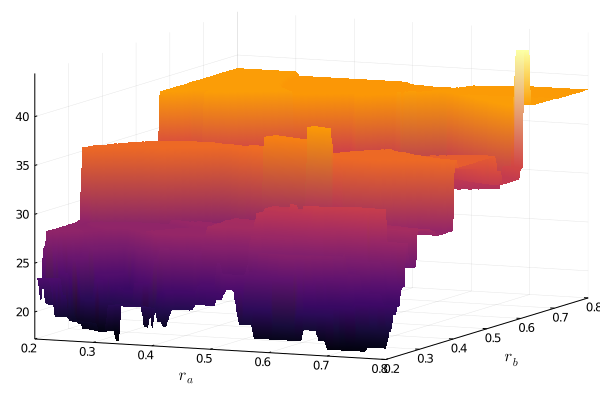

In [28]:
param = 0.2:0.005:0.8
test_substractive(iris, euclidean, param, param, 0.5, 0.15, db_index)


#### Manhattan norm

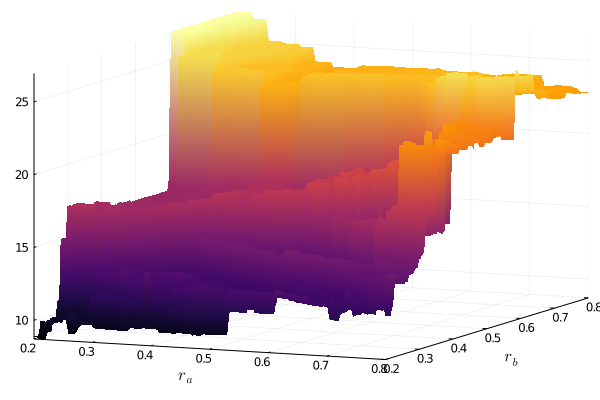

In [29]:
param = 0.2:0.005:0.8
test_substractive(iris, manhattan, param, param, 0.5, 0.15, db_index)


#### Mahalanobis norm

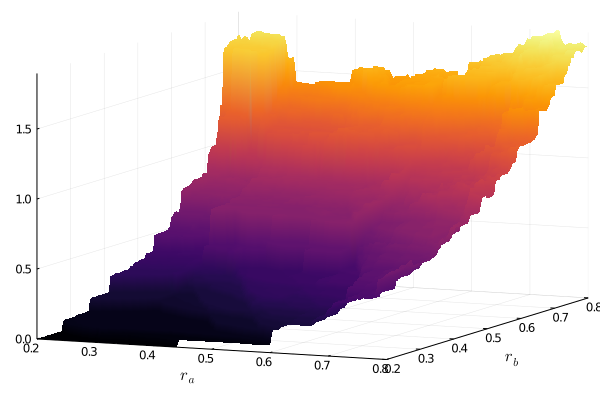

In [30]:
param = 0.2:0.005:0.8
IS = inv(cov(iris))
test_substractive(iris, mahalanobis, param, param, 0.5, 0.15, db_index, IS)


In the following cell, a table that compares each of the intra-clusters indexes
are shown in order to find an optimal value for the number of clusters.


In [79]:
# Euclidean
params = 0.1:0.01:0.3
matrix = zeros(length(params), 3)
for i in 1:length(params)
    param = params[i]
    protos = montain_clustering(iris, 10, euclidean, param / 2, param, 0.5, 0.15)
    matrix[i, 1] = size(protos)[1]
    matrix[i, 2] = db_index(iris, euclidean, protos)
    matrix[i, 3] = ch_index(iris, euclidean, protos)
end

matrix

21×3 Array{Float64,2}:
 6.0  32.5106  349.303
 6.0  32.5106  349.303
 6.0  29.1986  361.501
 6.0  29.1986  361.501
 5.0  36.1014  363.396
 4.0  31.5814  423.063
 4.0  28.9106  430.158
 4.0  28.9106  430.158
 4.0  28.9106  430.158
 3.0  36.9788  476.507
 3.0  36.9788  476.507
 3.0  36.9788  476.507
 3.0  36.9788  476.507
 3.0  36.9788  476.507
 3.0  36.9788  476.507
 3.0  36.9788  476.507
 3.0  36.9788  476.507
 3.0  37.3923  479.785
 3.0  37.3923  479.785
 2.0  40.9026  324.668
 2.0  37.3955  399.921

#### K-means

In [72]:
protos, u = k_means(iris, 3, euclidean, 0.01)
println("---- K-means ---- K = 3")
println("DB Index ", db_index(iris, euclidean, protos))
println("CH Index ", ch_index(iris, euclidean, protos))
println("\nExternal Index")
external_index(u, tags, verbose = true);

println()
protos, u = k_means(iris, 4, euclidean, 0.01)
println("---- K-means ---- K = 4")
println("DB Index ", db_index(iris, euclidean, protos))
println("CH Index ", ch_index(iris, euclidean, protos))
println("\nExternal Index")
external_index(u, tags, verbose = true);


---- K-means ---- K = 3
DB Index 31.45089563879995
CH Index 621.170675549067

External Index
Group 1 fully characterizes tag setosa

Group 3 partially classified tag versicolor
The number of bad classifications for each tag are:
	- Tag virginica ---- 4.0

Group 2 partially classified tag virginica
The number of bad classifications for each tag are:
	- Tag versicolor ---- 2.0


---- K-means ---- K = 4
DB Index 30.882959960838537
CH Index 458.9196728967923

External Index
Group 2 fully characterizes tag setosa

Group 4 fully characterizes tag setosa

Group 1 partially classified tag versicolor
The number of bad classifications for each tag are:
	- Tag virginica ---- 4.0

Group 3 partially classified tag virginica
The number of bad classifications for each tag are:
	- Tag versicolor ---- 2.0



#### Fuzzy c-means

In [74]:
protos = fuzzy_c_means(iris, 3, 5, euclidean, 0.01)
u, _ = find_membership(iris, euclidean, protos, [])
println("---- FC-means ---- C = 3")
println("DB Index ", db_index(iris, euclidean, protos))
println("CH Index ", ch_index(iris, euclidean, protos))
println("\nExternal Index")
external_index(u, tags, verbose = true);

println()
protos = fuzzy_c_means(iris, 4, 5, euclidean, 0.01)
u, _ = find_membership(iris, euclidean, protos, [])
println("---- FC-means ---- C = 4")
println("DB Index ", db_index(iris, euclidean, protos))
println("CH Index ", ch_index(iris, euclidean, protos))
println("\nExternal Index")
external_index(u, tags, verbose = true);


---- FC-means ---- C = 3
DB Index 37.75957574916397
CH Index 554.8928951114565

External Index
Group 2 fully characterizes tag setosa

Group 3 partially classified tag versicolor
The number of bad classifications for each tag are:
	- Tag virginica ---- 4.0

Group 1 partially classified tag virginica
The number of bad classifications for each tag are:
	- Tag versicolor ---- 2.0


---- FC-means ---- C = 4
DB Index 73.99783994732908
CH Index 100.24081249799514

External Index
Group 4 fully characterizes tag setosa

Group 2 fully characterizes tag versicolor

Group 3 fully characterizes tag versicolor

Group 1 partially classified tag virginica
The number of bad classifications for each tag are:
	- Tag versicolor ---- 12.0



### Embedded Data Set
In this cell, the embedded data set by using the t-Student Neighbor Embedding is
shown. It is importanto to remind that this algorithm is stochastic, hence the
run shown on the article is not necessarily the same as the one shown in this
notebook.


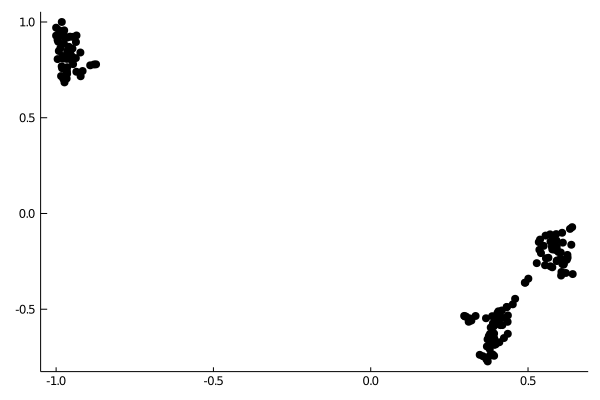

In [33]:
iris_lower = normalize(tsne(normalize(increase_dimensions(iris)), progress = false));
plot_data(iris_lower)


#### Euclidean

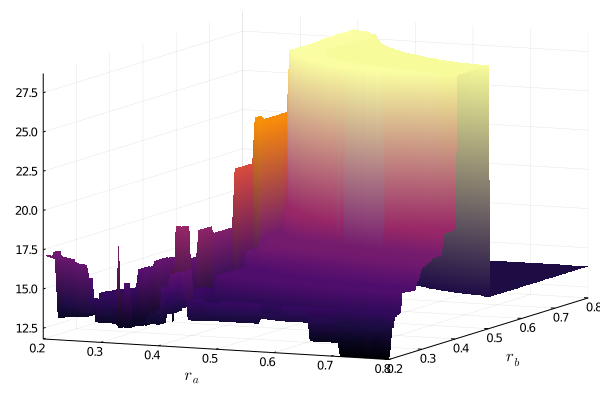

In [34]:
# Euclidean
param = 0.2:0.005:0.8
test_substractive(iris_lower, euclidean, param, param, 0.5, 0.15, db_index)


#### Manhattan

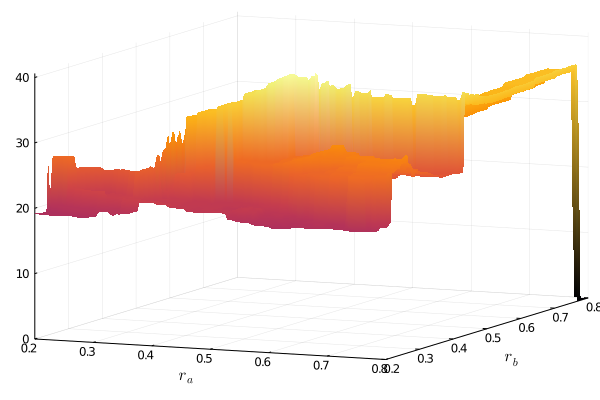

In [35]:
# Manhattan
param = 0.2:0.005:0.8
test_substractive(iris_lower, manhattan, param, param, 0.5, 0.15, db_index)


#### Mahalanobis

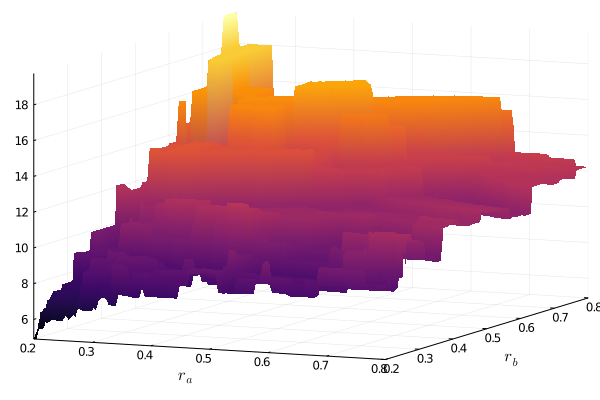

In [36]:
# Mahalanobis
param = 0.2:0.005:0.8
IS = inv(cov(iris_lower))
test_substractive(iris_lower, mahalanobis, param, param, 0.5, 0.15, db_index, IS)


In this next cell, the three graphs extracted to test the different values of the montain clustering algorithm in order to find the optimal value of clusters.

In [112]:
# Euclidean
param = 0.2:0.005:0.5
test_montain(iris_lower, 100, euclidean, param, 0.5, 0.15, dir_fig("iris/exploring-2d-emb-n.pdf"),
             dir_fig("iris/exploring-2d-emb-db.pdf"), dir_fig("iris/exploring-2d-emb-ch.pdf"))


#### Montain Clustering performance

In [46]:
# Montain clustering
protos_montain = montain_clustering(iris_lower, 100, euclidean, 0.2, 0.3, 0.5, 0.15)
u, _ = find_membership(iris_lower, euclidean, protos_montain, [])
println("---- Montain ----")
println("DB Index ", db_index(iris_lower, euclidean, protos_montain))
println("CH Index ", ch_index(iris_lower, euclidean, protos_montain))
println("\nExternal Index")
external_index(u, tags, verbose = true);


---- Montain ----
DB Index 17.94480088558767
CH Index 5278.617715240032

External Index
Group 2 fully characterizes tag setosa

Group 1 partially classified tag versicolor
The number of bad classifications for each tag are:
	- Tag virginica ---- 5.0

Group 3 fully characterizes tag virginica



#### K-means performance

---- K-means ----
DB Index 12.953316959483681
CH Index 8121.238868042954

External Index
Group 3 fully characterizes tag setosa

Group 1 partially classified tag versicolor
The number of bad classifications for each tag are:
	- Tag virginica ---- 2.0

Group 2 fully characterizes tag virginica



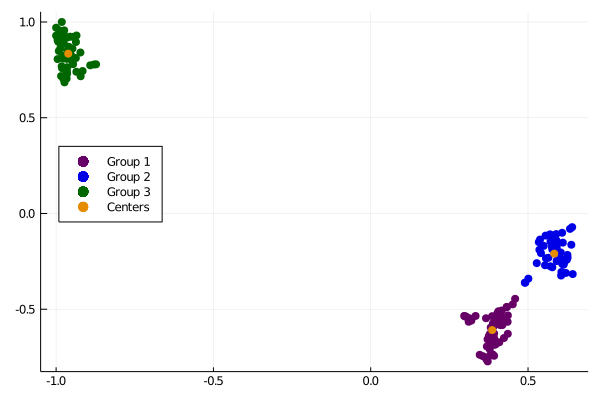

In [48]:
protos, u = k_means(iris_lower, 3, euclidean, 0.01)
println("---- K-means ----")
println("DB Index ", db_index(iris_lower, euclidean, protos))
println("CH Index ", ch_index(iris_lower, euclidean, protos))
println("\nExternal Index")
external_index(u, tags, verbose = true)
plot_clusters(protos, u, iris_lower, :left, xlabel = "", ylabel = "")


#### Fuzzy C-Means performance

---- FC-means ----
DB Index 138.41321119359577
CH Index 2064.9919171146853

External Index
Group 3 fully characterizes tag setosa

Group 2 partially classified tag versicolor
The number of bad classifications for each tag are:
	- Tag virginica ---- 2.0

Group 1 fully characterizes tag virginica



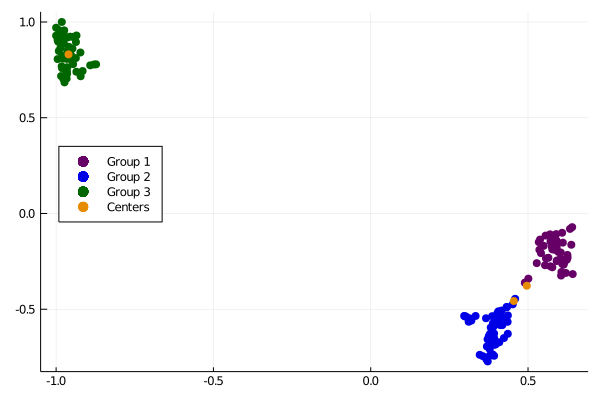

In [50]:
protos = fuzzy_c_means(iris_lower, 3, 5, euclidean, 0.01)
u, _ = find_membership(iris_lower, euclidean, protos, [])
println("---- FC-means ----")
println("DB Index ", db_index(iris_lower, euclidean, protos))
println("CH Index ", ch_index(iris_lower, euclidean, protos))
println("\nExternal Index")
external_index(u, tags, verbose = true)
plot_clusters(protos, u, iris_lower, :left, xlabel = "", ylabel = "")


#### Spectral clustering performance

In [162]:
membership = spectral_clustering(iris_lower, 3, euclidean, 0.01, 0.2)
external_index(membership, tags, verbose = true);
plot_clusters([], membership, iris_lower, :left, xlabel = "", ylabel = "")


Group 2 fully characterizes tag setosa

Group 1 partially classified tag versicolor
The number of bad classifications for each tag are:
	- Tag virginica ---- 2.0

Group 3 fully characterizes tag virginica



## Real Data Set
In the next cell, the functions that convert the categorical values to float ones. To have a more rich and complex data set, instead of completly picking a singular value for each answer a random, between a desired range, was calculated for each transformation.

In [26]:
function get_es(es_string)
    r = Random.rand(Float64)
    if es_string == "No decirle a nadie."
        return -255 + r*55
    elseif es_string == "Pido consejo a alguien cercano sobre cómo solucionarlo."
        return 100 + r*100
    elseif es_string == "Hablo lo que siento con la persona que tengo rabia."
        return 200 + r*55
    else
        return -200 + r*100
    end
end;

function get_output(output)
    r = Random.rand(Float64)
    if output == "Mucho."
        return 75 + r*25
    elseif output == "Muy poco."
        return r*25
    else
        return 40 + r*60
    end
end;


### CSV Reading

In [27]:
rows = CSV.Rows("results.csv")
data = []
for row in rows
    row_data = zeros(6)
    row_data[1] = parse(Float64, row[2])
    row_data[2] = parse(Float64, row[3])
    row_data[3] = get_es(row[4])
    row_data[4] = get_output(row[5])
    row_data[5] = get_output(row[6])
    row_data[6] = get_output(row[7])
    push!(data, row_data)
end;

data = normalize(collect(transpose(hcat(data...))));


### PAD Dataset Experimentation

In [55]:
params = 0.2:0.1:1.5
matrix = zeros(length(params), 3)
for i in 1:length(params)
    param = params[i]
    protos = substractive_clustering(data, euclidean, param, 1.5 * param, 0.5, 0.15)
    matrix[i, 1] = size(protos)[1]
    matrix[i, 2] = db_index(data, euclidean, protos)
    matrix[i, 3] = ch_index(data, euclidean, protos)
end

matrix

14×3 Array{Float64,2}:
 88.0   0.935806   42.1772
 32.0   4.40083    42.5319
 12.0  14.2515     57.4528
  8.0  22.166      68.2216
  6.0  27.0809     74.0645
  4.0  33.4802     94.0592
  3.0  31.0785    127.897
  2.0  42.2073    172.178
  2.0  42.2073    172.178
  2.0  42.2073    172.178
  2.0  42.2073    172.178
  2.0  42.2073    172.178
  2.0  42.2073    172.178
  2.0  50.1677    134.261

In [56]:
protos, u = k_means(data, 2, euclidean, 0.01)
println("---- K-means ---- K = 2")
println("DB Index ", db_index(data, euclidean, protos))
println("CH Index ", ch_index(data, euclidean, protos))

println()
protos, u = k_means(data, 3, euclidean, 0.01)
println("---- K-means ---- K = 3")
println("DB Index ", db_index(data, euclidean, protos))
println("CH Index ", ch_index(data, euclidean, protos))


---- K-means ---- K = 2
DB Index 42.89012937023224
CH Index 167.2367418643641

---- K-means ---- K = 3
DB Index 32.88263944697349
CH Index 102.17374353292688


In [58]:
protos = fuzzy_c_means(data, 2, 5, euclidean, 0.01)
println("---- FC-means ---- C = 2")
println("DB Index ", db_index(data, euclidean, protos))
println("CH Index ", ch_index(data, euclidean, protos))

println()
protos = fuzzy_c_means(data, 3, 5, euclidean, 0.01)
println("---- FC-means ---- C = 3")
println("DB Index ", db_index(data, euclidean, protos))
println("CH Index ", ch_index(data, euclidean, protos))


---- FC-means ---- C = 2
DB Index 105.31095575327555
CH Index 28.5420107264113

---- FC-means ---- C = 3
DB Index 1432.0655412268802
CH Index 58.731390864502494


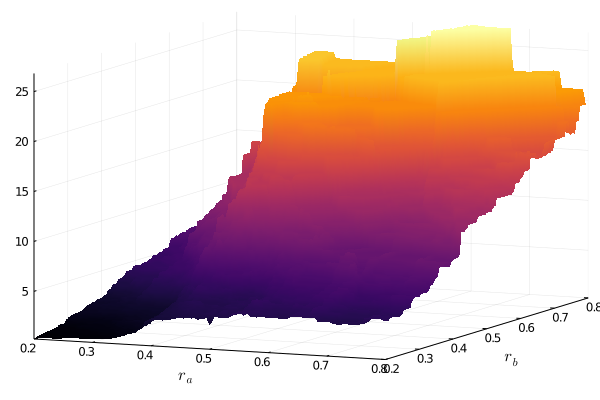

In [33]:
param = 0.2:0.005:0.8
test_substractive(data, euclidean, param, param, 0.5, 0.15, db_index)


## Higher Data Set

In [28]:
data_higher = normalize(increase_dimensions(data));

In [62]:
params = 0.3:0.1:1.5
matrix = zeros(length(params), 3)
for i in 1:length(params)
    param = params[i]
    protos = substractive_clustering(data_higher, euclidean, param, 1.5 * param, 0.5, 0.15)
    matrix[i, 1] = size(protos)[1]
    matrix[i, 2] = db_index(data_higher, euclidean, protos)
    matrix[i, 3] = ch_index(data_higher, euclidean, protos)
end

matrix

13×3 Array{Float64,2}:
 112.0   0.308733    8.25564
  80.0   3.27845     8.4508
  39.0   8.75727    12.6199
  11.0  23.827      22.6932
   4.0  53.0229     46.7989
   4.0  48.4747     45.3002
   3.0  47.228      60.1478
   2.0  51.7974    126.225
   2.0  51.7974    126.225
   2.0  51.7974    126.225
   2.0  51.7974    126.225
   2.0  51.7974    126.225
   2.0  51.7974    126.225

In [65]:
protos, u = k_means(data, 2, euclidean, 0.01)
println("---- K-means ----")
println("DB Index ", db_index(data, euclidean, protos))
println("CH Index ", ch_index(data, euclidean, protos))

println()
protos = fuzzy_c_means(data, 2, 5, euclidean, 0.01)
println("---- FC-means ----")
println("DB Index ", db_index(data, euclidean, protos))
println("CH Index ", ch_index(data, euclidean, protos))


---- K-means ----
DB Index 42.89012937023224
CH Index 167.23674186436406

---- FC-means ----
DB Index 1396.2734729588888
CH Index 0.17105004044874889


## Embedded data set

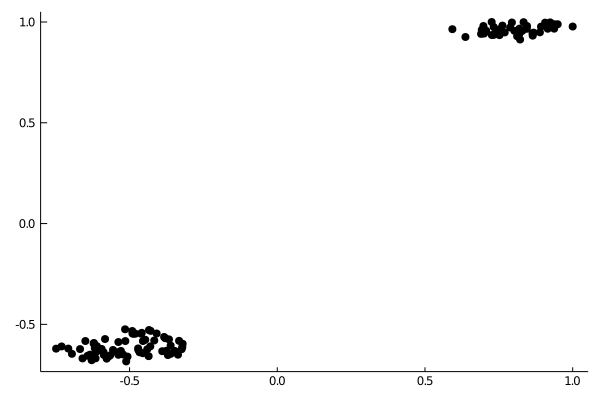

In [29]:
data_lower = normalize(tsne(data_higher, progress = false))
plot_data(data_lower)


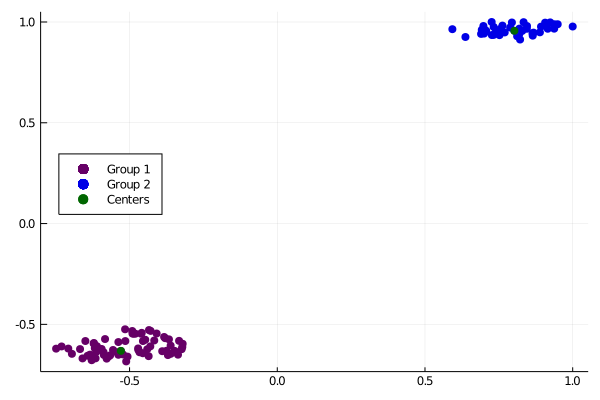

In [32]:
protos = substractive_clustering(data_lower, euclidean, 0.2, 0.4, 0.5, 0.15)
u, _ = find_membership(data_lower, euclidean, protos, [])
plot_clusters(protos, u, data_lower, :left, xlabel="", ylabel="")

---- K-means ----
DB Index 2.81950146283148
CH Index 34531.53372822685


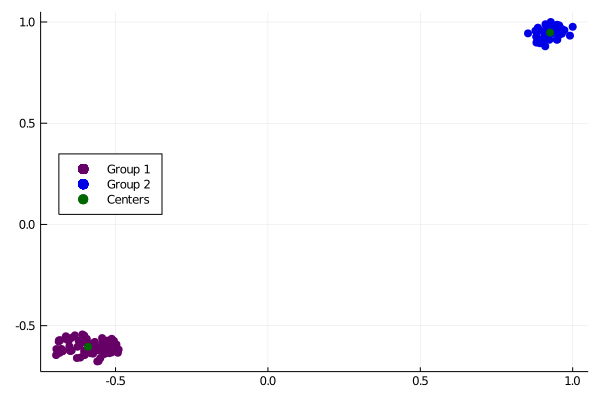

In [67]:
protos, u = k_means(data_lower, 2, euclidean, 0.01)
println("---- K-means ----")
println("DB Index ", db_index(data_lower, euclidean, protos))
println("CH Index ", ch_index(data_lower, euclidean, protos))
plot_clusters(protos, u, data_lower, :left, xlabel = "", ylabel = "")


---- FC-means ----
DB Index 2.817780432029669
CH Index 34496.72182069345


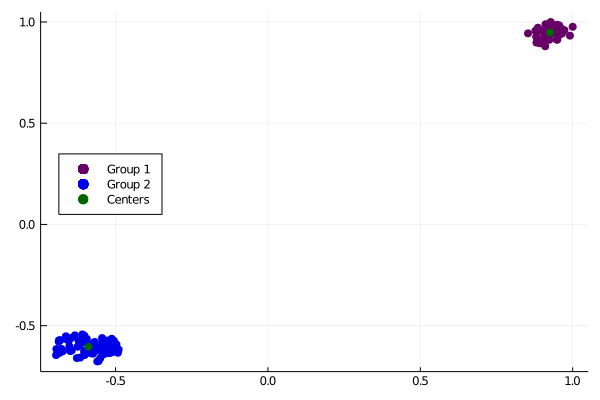

In [68]:
protos = fuzzy_c_means(data_lower, 2, 5, euclidean, 0.01)
u, _ = find_membership(data_lower, euclidean, protos, [])
println("---- FC-means ----")
println("DB Index ", db_index(data_lower, euclidean, protos))
println("CH Index ", ch_index(data_lower, euclidean, protos))
plot_clusters(protos, u, data_lower, :left, xlabel = "", ylabel = "")


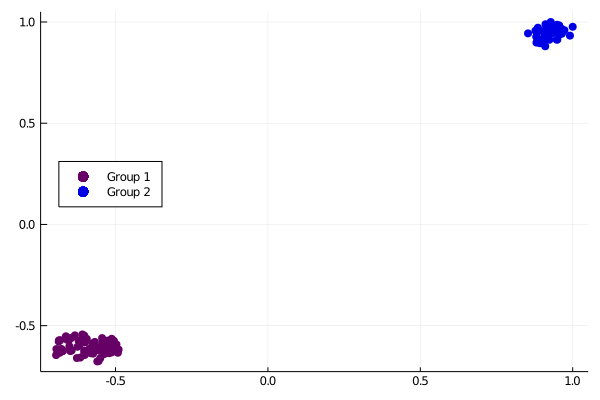

In [69]:
membership = spectral_clustering(data_lower, 2, euclidean, 0.01, 0.2)
plot_clusters([], membership, data_lower, :left, xlabel = "", ylabel = "")
